In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd


/home/alexchen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a = iter(x)
for i in a:
    first = i
    second = next(a, first)
    third = next(a,first)
    four = next(a, first)
    print(first)
    print(second)
    print(third)
    print(four)
    print("----")
    

1
2
3
4
----
5
6
7
8
----
9
10
9
9
----


In [3]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1,s2,s3), (s1,s2,s3,s4), (s2, s3,s4,s5), ..."
    a, b, c, d = tee(iterable, n=4)
    next(b, None)
    return zip(a, b)

In [4]:
batch_size = 128
n_mixture = 8
std = 0.025
radius = 1.0
latent_z_size =100
epochs = 2600

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5
dropout = 0.5

unroll_steps = 4

In [5]:
thetas = np.linspace(0, 2 * np.pi - 2 * np.pi / n_mixture, n_mixture)
centers = []
for i in range(0, len(thetas)):
    centers.append([radius * np.sin(thetas[i]), radius * np.cos(thetas[i])])
samples = []
for c in centers:
    samples.extend(np.random.normal(loc=c, scale=std, size=[8192, 2]).tolist())
#for s in range(len(samples)):
#    samples[s] = tf.convert_to_tensor(samples[s])
#for z in range(len(samples)):
#   samples[z] = [samples[z]]

#test output shape    
#o = np.array(samples)
#print(o.shape)
    
random.shuffle(samples)
samples = np.asarray(samples)
print(samples)
#print(samples.T[0:3])
train_data = mx.io.NDArrayIter(data = samples, batch_size = batch_size)

[[-0.70048962  0.7773251 ]
 [-0.0254361  -0.9790043 ]
 [-0.71376497 -0.71910148]
 ...
 [ 0.69156326  0.71886571]
 [ 0.72830703  0.72086373]
 [-0.02827189 -1.03202721]]


65536
2
[[-0.70048962 -0.0254361  -0.71376497 ...  0.69156326  0.72830703
  -0.02827189]
 [ 0.7773251  -0.9790043  -0.71910148 ...  0.71886571  0.72086373
  -1.03202721]]


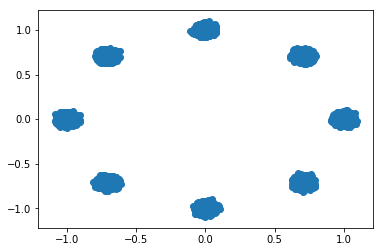

In [6]:
print(len(samples))
print(len(samples[0]))
#print(len(samples[0][0]))
print(samples.T)

x= samples.T[0]
y = samples.T[1]
plt.scatter(x,y)

In [7]:
netG = nn.Sequential()
with netG.name_scope():
    
    #Convolutional
    #initially 128 x 100 x 2
#     netG.add(nn.Conv1DTranspose(50, 4, in_channels = 100, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should now be 128 x 50 x 2
#     netG.add(nn.Conv1DTranspose(25, 4, in_channels = 50, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should still be 128 x 25 x 2
#     netG.add(nn.Conv1DTranspose(5, 4, in_channels = 25, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 5 x 2
#     netG.add(nn.Conv1DTranspose(2, 4,  in_channels = 5, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 2 x 2
#     netG.add(nn.Conv1DTranspose(1, 4,  in_channels = 2, padding = 2, strides =2))
#     netG.add(nn.LeakyReLU(0.2))
#     #should still be 128 x 1 x 2
    
    
    #Dense
    #initially 128 x 100 x 2
    netG.add(nn.Dense(1280))
    netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dropout(0.5))
    #netG.add(nn.Dense(640))
    #netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dense(320))
    netG.add(nn.Dropout(0.5))
    #netG.add(nn.LeakyReLU(0.2))
    netG.add(nn.Dense(2))
    
    

In [8]:
netD = nn.Sequential()
with netD.name_scope():
    
    #Convolutional
    #input is 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides = 2,padding = 2, in_channels = 1))
#     # should still be 256 x 1 x 1


    #Dense
    netD.add(nn.Dense(200))
    #netD.add(nn.Dropout(0.5))
    #netG.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dense(100))
    #netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Dense(25))
    netD.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dropout(0.5))
    netD.add(nn.Dense(1))
    
    
    


In [9]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.1), ctx = ctx)
netD.initialize(mx.init.Normal(0.1), ctx = ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
unrolledtrainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})


Begin
Done setting up Discriminator


INFO:root:
binary training acc at epoch 0: facc=0.000000
INFO:root:time: 1.310241
INFO:root:time: 1.310612


Epoch: 0
epoch 0
Plot 0


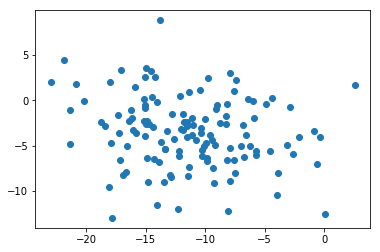

Plot 1


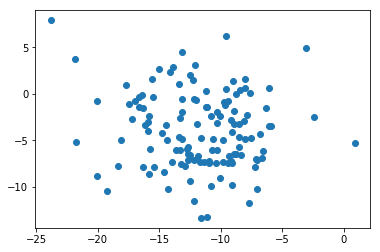

Plot 2


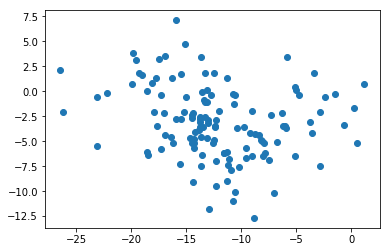

Plot 3


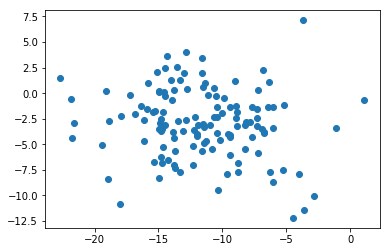

Plot 4


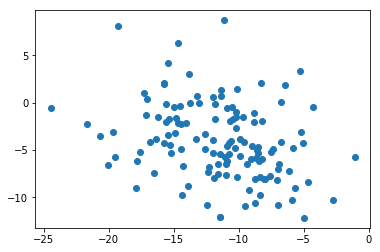


[[-12.7851     -5.1502   ]
 [ -7.525576   -3.299341 ]
 [ -9.304293    1.5857456]
 ...
 [ -6.984527   -7.0079637]
 [-14.338776   -9.695265 ]
 [ -9.567675   -4.1261277]]
<NDArray 768x2 @gpu(0)>
Epoch: 100


INFO:root:
binary training acc at epoch 200: facc=0.000000
INFO:root:time: 1.265369
INFO:root:time: 1.265800


Epoch: 200
epoch 200
Plot 0


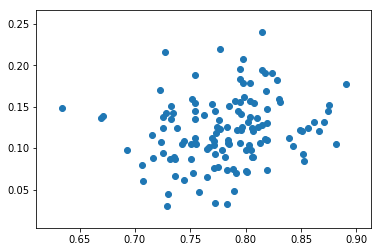

Plot 1


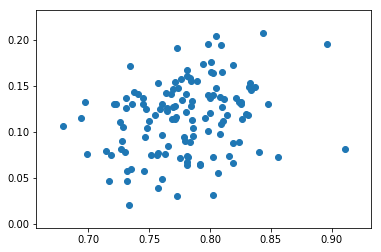

Plot 2


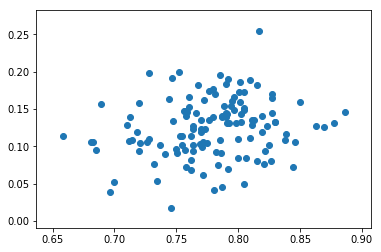

Plot 3


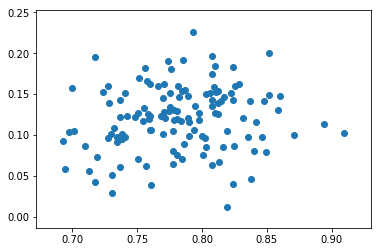

Plot 4


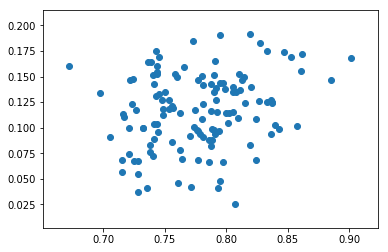


[[0.8098419  0.16048987]
 [0.7603031  0.16496883]
 [0.8095895  0.17664813]
 ...
 [0.78873837 0.08766297]
 [0.75033605 0.13516043]
 [0.7410783  0.10392906]]
<NDArray 768x2 @gpu(0)>
Epoch: 300


INFO:root:
binary training acc at epoch 400: facc=0.000000
INFO:root:time: 1.275450
INFO:root:time: 1.278308


Epoch: 400
epoch 400
Plot 0


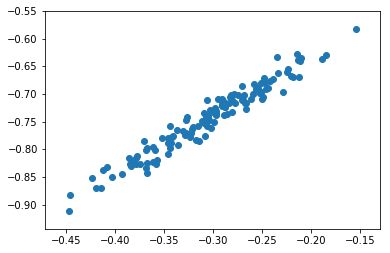

Plot 1


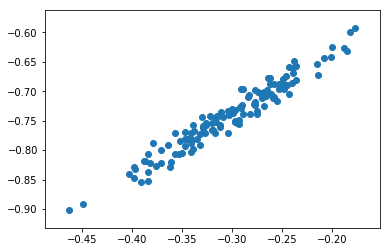

Plot 2


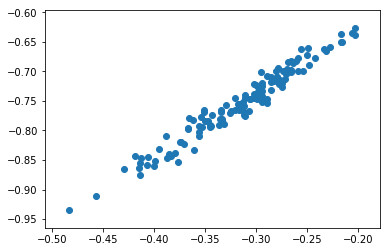

Plot 3


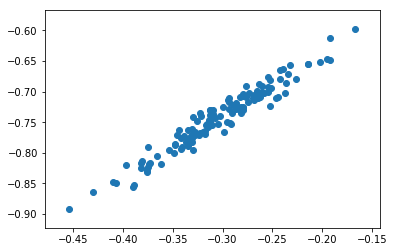

Plot 4


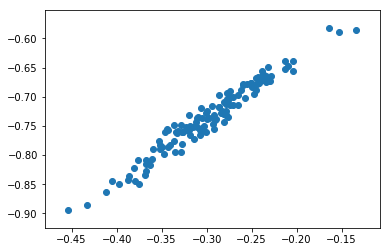


[[-0.3379916  -0.7631444 ]
 [-0.3121338  -0.7845023 ]
 [-0.29781199 -0.7418144 ]
 ...
 [-0.33605444 -0.7490342 ]
 [-0.27410716 -0.7142257 ]
 [-0.3026464  -0.75087506]]
<NDArray 768x2 @gpu(0)>
Epoch: 500


INFO:root:
binary training acc at epoch 600: facc=0.000000
INFO:root:time: 1.265505
INFO:root:time: 1.265878


Epoch: 600
epoch 600
Plot 0


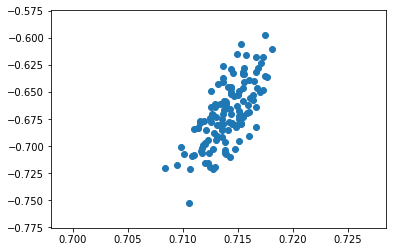

Plot 1


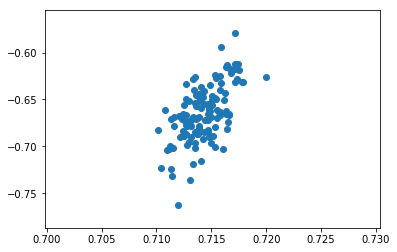

Plot 2


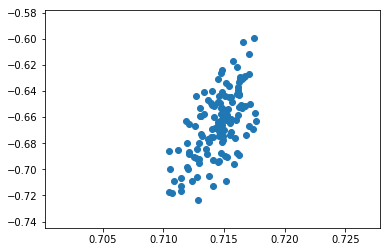

Plot 3


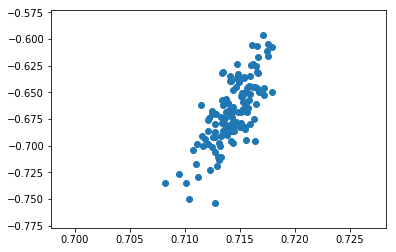

Plot 4


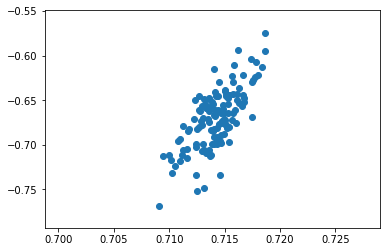


[[ 0.7142006  -0.6604846 ]
 [ 0.7133481  -0.6703023 ]
 [ 0.7168602  -0.66088575]
 ...
 [ 0.7091213  -0.76814914]
 [ 0.71567494 -0.6232022 ]
 [ 0.7163186  -0.6361989 ]]
<NDArray 768x2 @gpu(0)>
Epoch: 700


INFO:root:
binary training acc at epoch 800: facc=0.000000
INFO:root:time: 1.276726
INFO:root:time: 1.277290


Epoch: 800
epoch 800
Plot 0


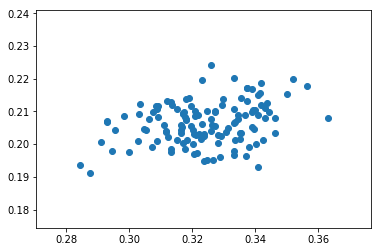

Plot 1


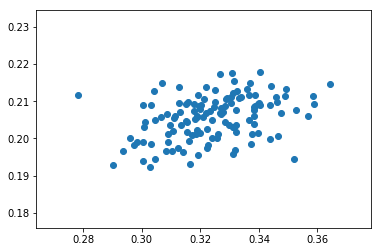

Plot 2


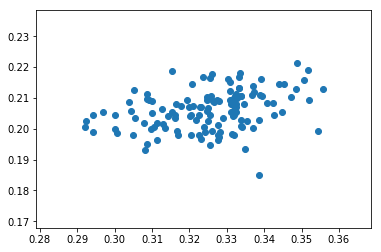

Plot 3


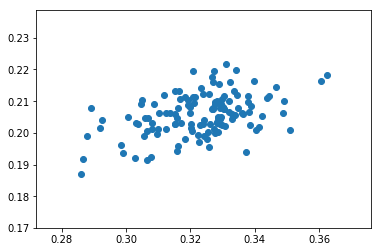

Plot 4


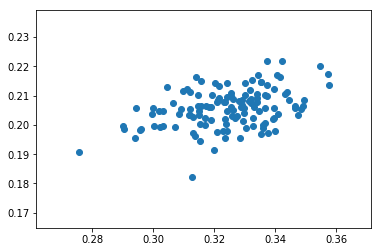


[[0.32960948 0.19972181]
 [0.3194232  0.19943628]
 [0.32728186 0.20335266]
 ...
 [0.31403935 0.21626139]
 [0.31552792 0.20022583]
 [0.3294184  0.20118949]]
<NDArray 768x2 @gpu(0)>
Epoch: 900


INFO:root:
binary training acc at epoch 1000: facc=0.000000
INFO:root:time: 1.269920
INFO:root:time: 1.270338


Epoch: 1000
epoch 1000
Plot 0


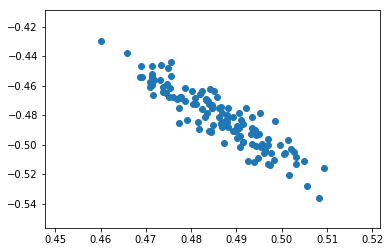

Plot 1


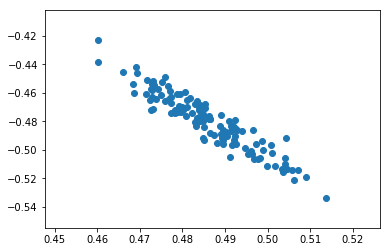

Plot 2


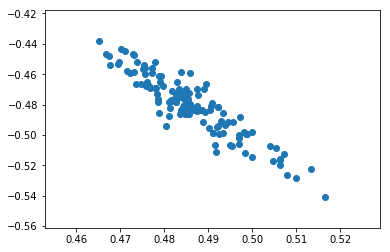

Plot 3


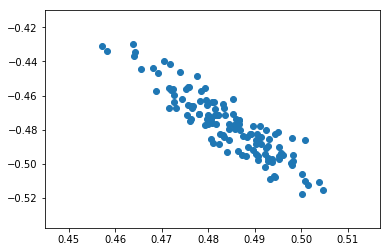

Plot 4


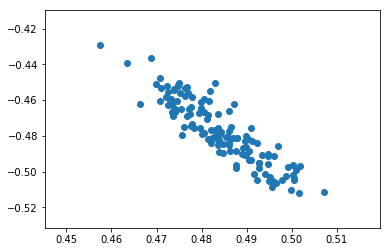


[[ 0.48048222 -0.4686679 ]
 [ 0.4743182  -0.45834723]
 [ 0.48402047 -0.46941057]
 ...
 [ 0.4836136  -0.4756228 ]
 [ 0.49873316 -0.5025027 ]
 [ 0.47682095 -0.46882752]]
<NDArray 768x2 @gpu(0)>
Epoch: 1100


INFO:root:
binary training acc at epoch 1200: facc=0.000000
INFO:root:time: 1.279609
INFO:root:time: 1.279997


Epoch: 1200
epoch 1200
Plot 0


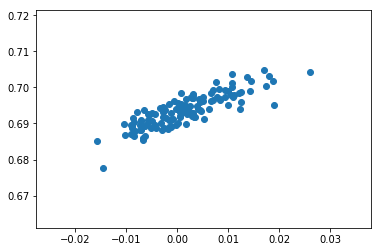

Plot 1


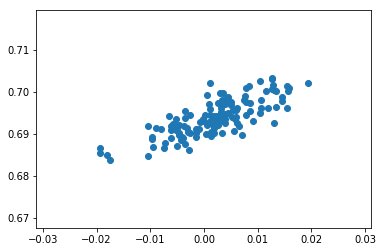

Plot 2


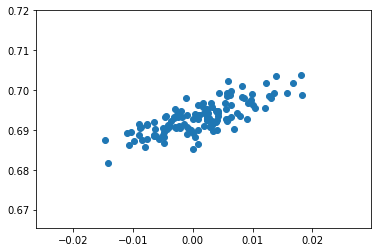

Plot 3


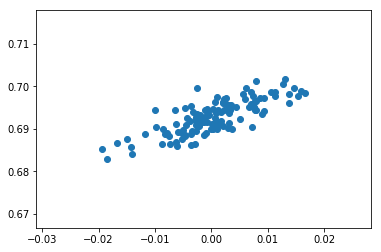

Plot 4


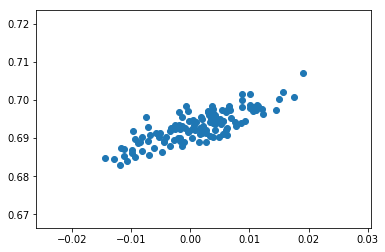


[[ 2.6481152e-03  6.9394141e-01]
 [-2.6111901e-03  6.8888736e-01]
 [ 5.5432320e-05  6.9349241e-01]
 ...
 [-1.9786060e-03  6.9335759e-01]
 [ 1.6168952e-03  6.9253260e-01]
 [ 3.8065016e-03  6.9645911e-01]]
<NDArray 768x2 @gpu(0)>
Epoch: 1300


INFO:root:
binary training acc at epoch 1400: facc=0.000000
INFO:root:time: 1.267269
INFO:root:time: 1.267794


Epoch: 1400
epoch 1400
Plot 0


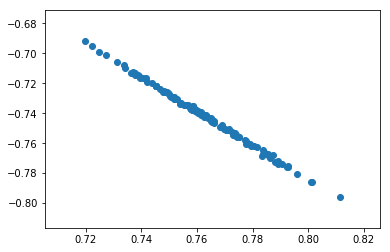

Plot 1


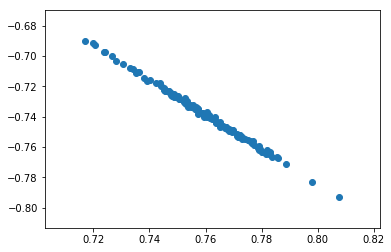

Plot 2


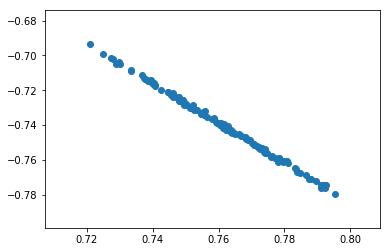

Plot 3


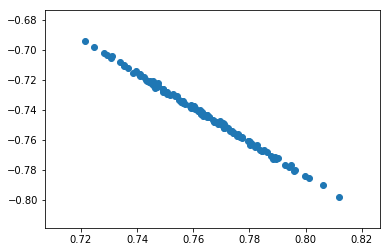

Plot 4


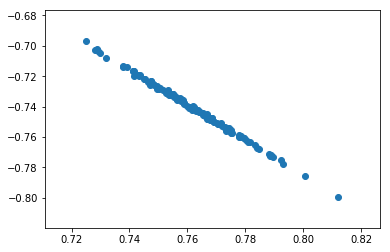


[[ 0.7498455  -0.72635967]
 [ 0.75453573 -0.7323631 ]
 [ 0.75302994 -0.732067  ]
 ...
 [ 0.7298588  -0.70507586]
 [ 0.7577645  -0.73607355]
 [ 0.76675886 -0.7446451 ]]
<NDArray 768x2 @gpu(0)>
Epoch: 1500


INFO:root:
binary training acc at epoch 1600: facc=0.000000
INFO:root:time: 1.266252
INFO:root:time: 1.266677


Epoch: 1600
epoch 1600
Plot 0


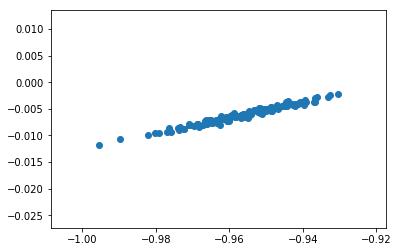

Plot 1


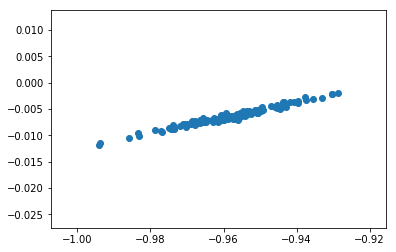

Plot 2


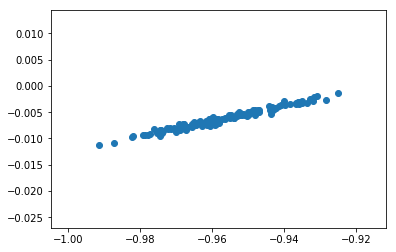

Plot 3


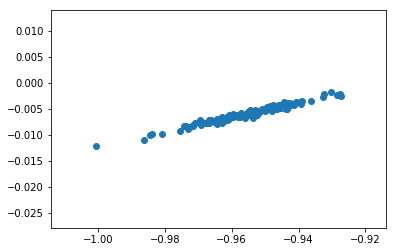

Plot 4


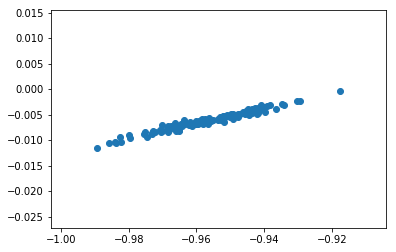


[[-0.9741355  -0.00817063]
 [-0.9453696  -0.00490421]
 [-0.9722048  -0.0093078 ]
 ...
 [-0.94475937 -0.0038874 ]
 [-0.96864784 -0.0078927 ]
 [-0.96786386 -0.00784707]]
<NDArray 768x2 @gpu(0)>
Epoch: 1700


INFO:root:
binary training acc at epoch 1800: facc=0.000000
INFO:root:time: 1.275038
INFO:root:time: 1.277027


Epoch: 1800
epoch 1800
Plot 0


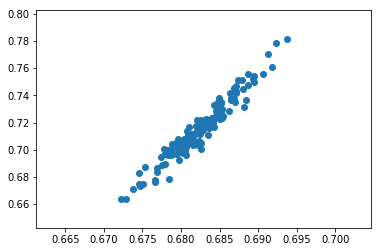

Plot 1


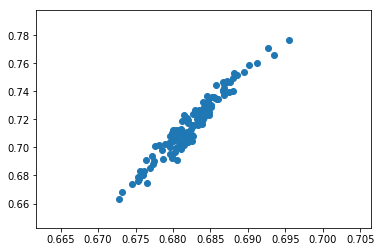

Plot 2


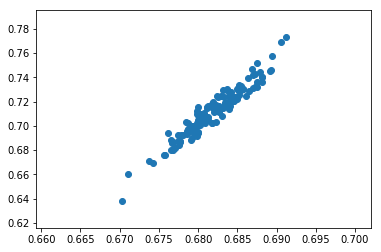

Plot 3


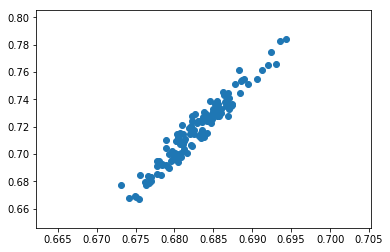

Plot 4


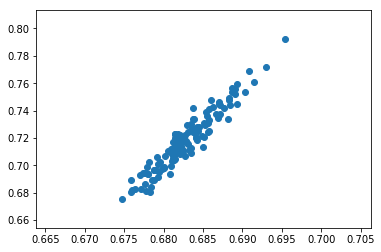


[[0.67206174 0.65320647]
 [0.693954   0.7807848 ]
 [0.689139   0.7558212 ]
 ...
 [0.6834699  0.7088208 ]
 [0.67767775 0.6943213 ]
 [0.6813153  0.7039163 ]]
<NDArray 768x2 @gpu(0)>
Epoch: 1900


INFO:root:
binary training acc at epoch 2000: facc=0.000000
INFO:root:time: 1.271865
INFO:root:time: 1.272244


Epoch: 2000
epoch 2000
Plot 0


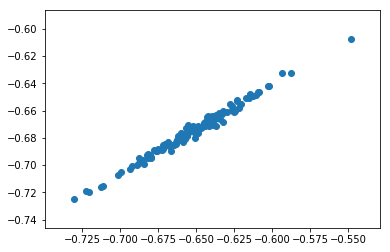

Plot 1


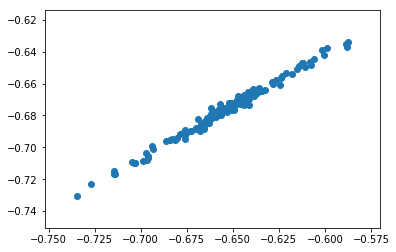

Plot 2


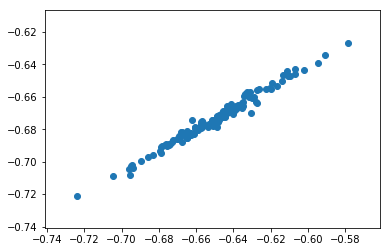

Plot 3


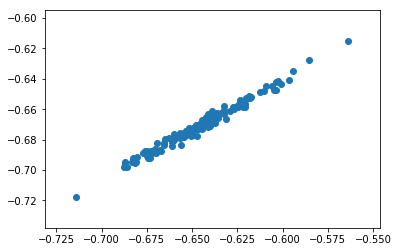

Plot 4


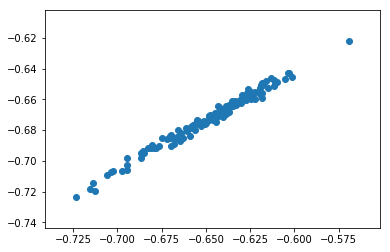


[[-0.64756054 -0.6688475 ]
 [-0.64031804 -0.6672561 ]
 [-0.6558786  -0.6755719 ]
 ...
 [-0.68018705 -0.6897525 ]
 [-0.6365829  -0.6647183 ]
 [-0.6720064  -0.68582845]]
<NDArray 768x2 @gpu(0)>
Epoch: 2100


INFO:root:
binary training acc at epoch 2200: facc=0.000000
INFO:root:time: 1.268101
INFO:root:time: 1.268621


Epoch: 2200
epoch 2200
Plot 0


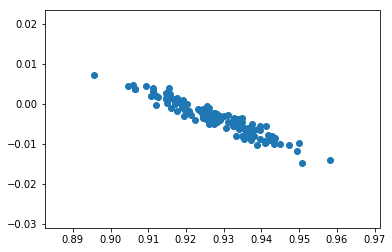

Plot 1


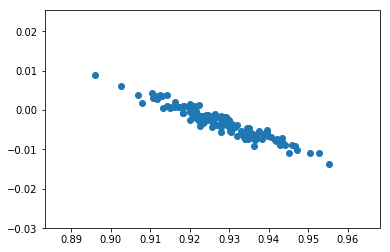

Plot 2


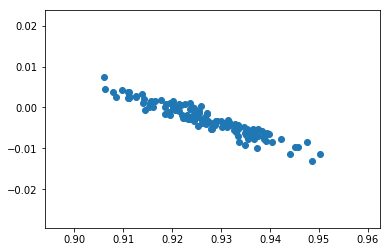

Plot 3


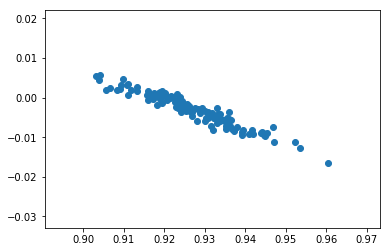

Plot 4


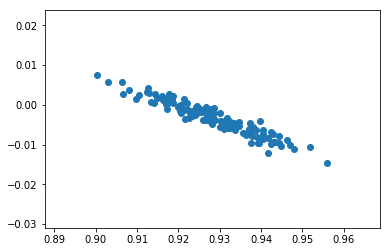


[[ 9.2629296e-01 -3.4109354e-03]
 [ 9.3092662e-01 -4.3093562e-03]
 [ 9.2689055e-01 -2.5025308e-03]
 ...
 [ 9.2063838e-01 -6.8426132e-05]
 [ 9.3460065e-01 -4.2206943e-03]
 [ 9.3058771e-01 -5.2358806e-03]]
<NDArray 768x2 @gpu(0)>
Epoch: 2300


INFO:root:
binary training acc at epoch 2400: facc=0.000000
INFO:root:time: 1.266903
INFO:root:time: 1.267466


Epoch: 2400
epoch 2400
Plot 0


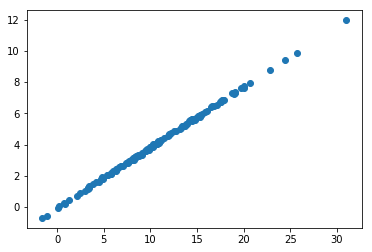

Plot 1


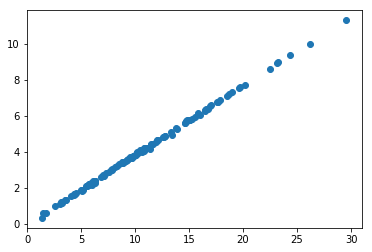

Plot 2


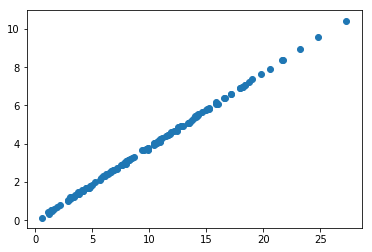

Plot 3


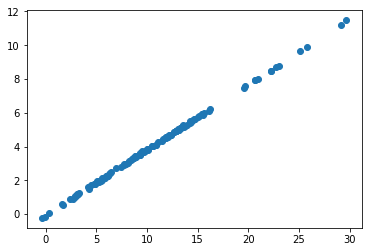

Plot 4


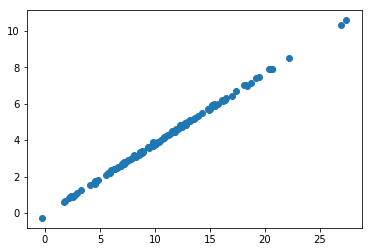


[[ 9.988303   3.8132386]
 [18.681726   7.1967654]
 [ 5.2646813  1.986598 ]
 ...
 [11.703711   4.4402733]
 [14.888346   5.671035 ]
 [12.435557   4.7407656]]
<NDArray 768x2 @gpu(0)>
Epoch: 2500


INFO:root:
binary training acc at epoch 2600: facc=0.000000
INFO:root:time: 1.259611
INFO:root:time: 1.260028


Epoch: 2600
epoch 2600
Plot 0


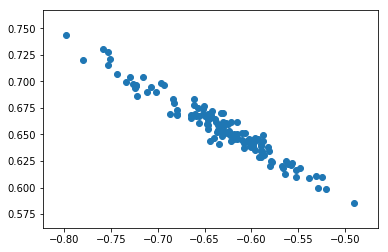

Plot 1


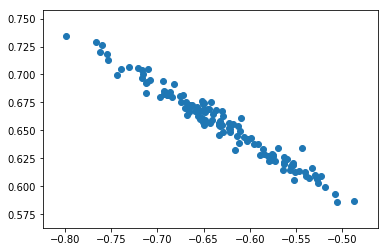

Plot 2


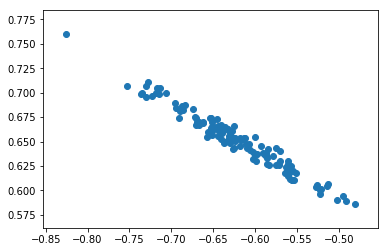

Plot 3


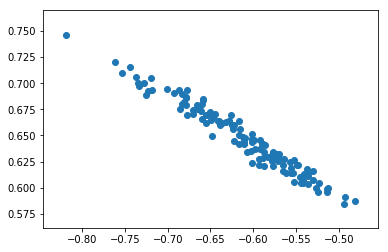

Plot 4


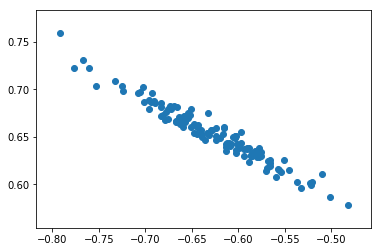


[[-0.56103545  0.61836064]
 [-0.58654565  0.6339294 ]
 [-0.5769654   0.6259489 ]
 ...
 [-0.61365014  0.6387575 ]
 [-0.6399422   0.6568495 ]
 [-0.5854282   0.62958276]]
<NDArray 768x2 @gpu(0)>


In [10]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size * 4,), ctx = ctx)
fake_label = nd.zeros((batch_size * 4,), ctx = ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred>0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)


stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)
print("Begin")


#set up Discriminator first

for i in range(250):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    #print("RUNNING")
    for batch1 in train_data:
        batch2 = next(train_data, batch1)
        batch3 = next(train_data, batch1)
        batch4 = next(train_data, batch1)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0], dim = 0)).as_in_context(ctx)
        
        
        
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        real_label_noise = mx.ndarray.add(real_label, noise)
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        fake_label_noise = mx.ndarray.add(fake_label, noise)
        #print("TESTING 123")
        #print(real_label_noise)
        #print(fake_label_noise)
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z3 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z4 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label_noise,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)
            
            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)
            

            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label_noise)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label_noise,], [output,])

        trainerD.step(data.shape[0])
    name, acc = metric.get()
    metric.reset()
    
print("Done setting up Discriminator")
for epoch in range(epochs+1):
    train_data.reset()
    tic = time.time()
    btic = time.time()
    iter = 0
    #print("RUNNING")
    for batch1 in train_data:
        batch2 = next(train_data, batch1)
        batch3 = next(train_data, batch1)
        batch4 = next(train_data, batch1)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0], dim = 0)).as_in_context(ctx)
        
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z3 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z4 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label_noise,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)
            
            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)
            

            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label_noise)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label_noise,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake1 = netG(latent_z1)
            fake2 = netG(latent_z2)
            fake3 = netG(latent_z3)
            fake4 = netG(latent_z4)
            #print(fake1)
            #rint(fake1.T)
            #print(fake1.T[0])
           # print(fake1.T[0][1])
            
            
            #only add if using dense
            #fake1 = fake1.reshape((128, 1, 2))
            #fake2 = fake2.reshape((128, 1, 2))
            
            output = netD(mx.ndarray.concat(fake1, fake2, fake3, fake4, dim = 0)).reshape((-1, 1))
            errG = loss(output, real_label_noise)
            errG.backward()

        trainerG.step(mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0]).shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            #logging.firstFake info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            #logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
            #         %(nd.mean(errD).asscalar(),
            #           nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    #logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    #logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake1[0]
    #print("testing")
    #print("Fake data")
    #print(fake1)
    ##print("fake data transposed")
    #print(fake1.T)
    #print(len(fake))0
    #print(len(fake[0]))
    #print(len(fake[0][0]))
    #print(fake)
    
    
    #test small print
    #print("epoch %d" % (epoch))
    #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
    #x= fake.T[0][0].asnumpy().tolist()
    #y = fake.T[1][0].asnumpy().tolist()
    #print("Plot")
    #plt.scatter(x,y)
    #plt.show()
    
    
    
    
    #real print
    if(epoch%100 ==0):
        print("Epoch: %d" % epoch)
    if(epoch%200 == 0):# or epoch % 200 == 1 or epoch % 200 == 2 or epoch % 200 == 3):
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))
        logging.info('time: %f' % (time.time() - tic))
        print("epoch %d" % (epoch))
        
        #For convolution?
        #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
        #x= fake1.T[0][0].asnumpy().tolist()
        #y = fake1.T[0][1].asnumpy().tolist()
        latent1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        fake = netG(latent1)
        for i in range(5):
            latent = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
            fakeadd = netG(latent)
            x = fakeadd.T[0].asnumpy().tolist()
            y = fakeadd.T[1].asnumpy().tolist()
            print("Plot %d" % i)
            plt.scatter(x,y)
            plt.show()
            fake = mx.ndarray.concat(fake, fakeadd, dim = 0)
        #fake = mx.ndarray.concat(fake1, fake2, fake3, fake4, dim = 0)
        

        #print("X: ")
        #print(fake.T[0][0])
        #print("Y: ")
        #print(fake.T[0][1])
        #print("")
        #print("")
        print(fake)


        #plt.show()   
    
    # visualize(fake_img)
    # plt.show()
